In [8]:
import numpy as np
import matplotlib.pyplot as plt
from MCEq.core import MCEqRun
import crflux.models as pm
import os

# Setup plotting style
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# First, let's discover what primary models are actually available
print("Discovering available primary cosmic ray models...")

# List all potential models to test
potential_models = []

# Check for HillasGaisser models
if hasattr(pm, 'HillasGaisser2012'):
    potential_models.extend([
        (pm.HillasGaisser2012, "H4a"),
        (pm.HillasGaisser2012, "H3a"),
        (pm.HillasGaisser2012, "H2a"),
    ])

# Check for GaisserStanevTilav models
if hasattr(pm, 'GaisserStanevTilav'):
    potential_models.extend([
        (pm.GaisserStanevTilav, "3-gen"),
        (pm.GaisserStanevTilav, "4-gen"),
        (pm.GaisserStanevTilav, "5-gen"),
    ])


print(f"Found {len(potential_models)} potential primary models to test")

# Test which ones actually work
working_primary_models = []
test_interaction = 'SIBYLL23C'

print("\nTesting primary model compatibility...")

for prim_model_tuple in potential_models:
    prim_name = f"{prim_model_tuple[0].__name__}({prim_model_tuple[1]})"
    
    try:
        print(f"Testing {prim_name:45}...", end=" ")
        mceq_test = MCEqRun(
            interaction_model=test_interaction,
            primary_model=prim_model_tuple,
            theta_deg=0.0
        )
        mceq_test.solve()
        test_flux = mceq_test.get_solution('total_nue', 3)
        
        working_primary_models.append(prim_model_tuple)
        print(" WORKS")
        del mceq_test
        
    except Exception as e:
        error_msg = str(e)
        if "not found" in error_msg or "not available" in error_msg:
            print(" NOT AVAILABLE")
        else:
            print(f" FAILED: {str(e)[:35]}...")

# Select the most interesting models for comparison (4-6 models)
if len(working_primary_models) > 6:
    # Priority selection to ensure diversity
    final_primaries = []
    families_seen = set()
    
    for prim_model in working_primary_models:
        family = prim_model[0].__name__
        if family not in families_seen:
            final_primaries.append(prim_model)
            families_seen.add(family)
        elif len(final_primaries) < 6:
            # Add some variants from the same family
            final_primaries.append(prim_model)
    
    working_primary_models = final_primaries[:6]

print(f"\n Selected {len(working_primary_models)} primary models:")
for i, prim_model in enumerate(working_primary_models):
    print(f"  {i+1}. {prim_model[0].__name__}({prim_model[1]})")

angles = [0.0, 22.5, 45.0]  # Zenith angles in degrees
mag = 3  # Exponent for E^3 * Phi normalization

primary_models = working_primary_models

Discovering available primary cosmic ray models...
Found 6 potential primary models to test

Testing primary model compatibility...
Testing HillasGaisser2012(H4a)                       ... MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H4a
 WORKS
Testing HillasGaisser2012(H3a)                       ... MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
 WORKS
Testing HillasGaisser2012(H2a)                       ... MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi

In [9]:
# Force one model from each family: EPOS, QGSJET, and SIBYLL
model_families = {
    'EPOS': ['EPOS-LHC', 'EPOS1.99'],
    'QGSJET': ['QGSJETII-04', 'QGSJETII-03', 'QGSJETII-02', 'QGSJET01'],
    'SIBYLL': ['SIBYLL23C', 'SIBYLL2.3c', 'SIBYLL2.3']
}

working_models = []
test_primary = primary_models[0]  # Use first working primary model for testing

print("Forcing one model from each family: EPOS, QGSJET, and SIBYLL...")

# Test each family until we get one working model from each
for family, models in model_families.items():
    print(f"\n Testing {family} family:")
    family_working = False
    
    for model in models:
        if family_working:  # Already found a working model for this family
            continue
            
        try:
            print(f"  Testing {model:20}...", end=" ")
            mceq_test = MCEqRun(
                interaction_model=model,
                primary_model=test_primary,
                theta_deg=0.0
            )
            # Test actual calculation
            mceq_test.solve()
            test_flux = mceq_test.get_solution('total_nue', mag)
            
            working_models.append(model)
            family_working = True
            print("✓ WORKS")
            del mceq_test
            
        except Exception as e:
            error_msg = str(e)
            if "not found" in error_msg or "not available" in error_msg:
                print("✗ NOT AVAILABLE")
            else:
                print(f"✗ FAILED: {error_msg[:40]}...")

# Check if we got all three families
families_obtained = set()
for model in working_models:
    if any(epos in model for epos in ['EPOS']):
        families_obtained.add('EPOS')
    elif any(qgs in model for qgs in ['QGSJET']):
        families_obtained.add('QGSJET')
    elif any(sib in model for sib in ['SIBYLL']):
        families_obtained.add('SIBYLL')

print(f"\n Families obtained: {list(families_obtained)}")

# Final arrangement: Ensure we have exactly one from each family if possible
final_models = []
families_used = set()

# Add one model from each family, preferring newer versions
preference_order = [
    'EPOS-LHC', 'EPOS1.99',
    'QGSJETII-04', 'QGSJETII-03', 'QGSJETII-02', 'QGSJET01',
    'SIBYLL23C', 'SIBYLL2.3c', 'SIBYLL2.3'
]

for model in preference_order:
    if model in working_models:
        family = None
        if any(epos in model for epos in ['EPOS']):
            family = 'EPOS'
        elif any(qgs in model for qgs in ['QGSJET']):
            family = 'QGSJET'
        elif any(sib in model for sib in ['SIBYLL']):
            family = 'SIBYLL'
        
        if family and family not in families_used:
            final_models.append(model)
            families_used.add(family)
        
        # Stop when we have one from each family
        if len(families_used) == 3:
            break

# If we still don't have all three, add any remaining working models
for model in working_models:
    if model not in final_models and len(final_models) < 3:
        final_models.append(model)

working_models = final_models

print(f"\n Final working interaction models: {working_models}")

# Verify we have models from all three families
final_families = set()
for model in working_models:
    if any(epos in model for epos in ['EPOS']):
        final_families.add('EPOS')
    elif any(qgs in model for qgs in ['QGSJET']):
        final_families.add('QGSJET')
    elif any(sib in model for sib in ['SIBYLL']):
        final_families.add('SIBYLL')

print(f" Model families in final selection: {list(final_families)}")

if len(final_families) < 3:
    print(" Warning: Could not get models from all three families")
    print("   Proceeding with available models...")

if not working_models:
    raise RuntimeError("CRITICAL: No interaction models working! Cannot proceed.")

Forcing one model from each family: EPOS, QGSJET, and SIBYLL...

 Testing EPOS family:
  Testing EPOS-LHC            ... MCEqRun::set_interaction_model(): EPOSLHC
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H4a
✓ WORKS

 Testing QGSJET family:
  Testing QGSJETII-04         ... MCEqRun::set_interaction_model(): QGSJETII04
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H4a
✓ WORKS

 Testing SIBYLL family:
  Testing SIBYLL23C           ... MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile 

In [4]:
print("\n" + "="*60)
print("STARTING COMPREHENSIVE FLUX CALCULATION")
print(f"Interaction Models: {working_models}")
print(f"Primary Models: {[f'{pm[0].__name__}({pm[1]})' for pm in primary_models]}")
print("="*60)

# Storage for all results
all_results = {}
e_grid = None

for int_model in working_models:
    print(f"\n Processing interaction model: {int_model}")
    model_results = {}
    
    for prim_model_tuple in primary_models:
        prim_name = f"{prim_model_tuple[0].__name__}({prim_model_tuple[1]})"
        print(f"  Primary model: {prim_name}")
        
        try:
            # Initialize MCEq for this combination
            mceq_run = MCEqRun(
                interaction_model=int_model,
                primary_model=prim_model_tuple,
                theta_deg=0.0
            )
            
            # Set energy grid on first successful run
            if e_grid is None:
                e_grid = mceq_run.e_grid
            
            # Initialize flux storage for this primary model
            angle_fluxes = {
                'nue_total': np.zeros_like(e_grid),
                'nue_conv': np.zeros_like(e_grid), 
                'nue_pr': np.zeros_like(e_grid),
                'angles_used': 0
            }
            
            # Calculate fluxes for each angle
            for theta in angles:
                try:
                    mceq_run.set_theta_deg(theta)
                    mceq_run.solve()
                    
                    # Get E^3-weighted fluxes for electron neutrinos
                    nue_total = mceq_run.get_solution('total_nue', mag)
                    nue_conv = mceq_run.get_solution('conv_nue', mag)
                    nue_pr = mceq_run.get_solution('pr_nue', mag)
                    
                    # Sum over angles
                    angle_fluxes['nue_total'] += nue_total
                    angle_fluxes['nue_conv'] += nue_conv
                    angle_fluxes['nue_pr'] += nue_pr
                    angle_fluxes['angles_used'] += 1
                    
                    print(f"    Angle {theta:5.1f}° completed", end="\r")
                    
                except Exception as e:
                    print(f"     Angle {theta:5.1f}° failed: {str(e)[:30]}...")
                    continue
            
            # Average over successful angles
            if angle_fluxes['angles_used'] > 0:
                for key in ['nue_total', 'nue_conv', 'nue_pr']:
                    angle_fluxes[key] /= angle_fluxes['angles_used']
                
                model_results[prim_name] = angle_fluxes
                print(f"     {prim_name} completed ({angle_fluxes['angles_used']}/{len(angles)} angles)")
            else:
                print(f"     {prim_name} failed for all angles")
            
            del mceq_run
            
        except Exception as e:
            print(f"    {prim_name} initialization failed: {str(e)[:50]}...")
            continue
    
    all_results[int_model] = model_results

print(f"\n Calculation completed. Results stored for {len(all_results)} interaction models.")


STARTING COMPREHENSIVE FLUX CALCULATION
Interaction Models: ['EPOS-LHC', 'QGSJETII-04', 'SIBYLL23C']
Primary Models: ['HillasGaisser2012(H4a)', 'HillasGaisser2012(H3a)', 'GaisserStanevTilav(3-gen)', 'GaisserStanevTilav(4-gen)', 'Thunman(TIG)', 'Thunman(TIG_1996)']

 Processing interaction model: EPOS-LHC
  Primary model: HillasGaisser2012(H4a)
MCEqRun::set_interaction_model(): EPOSLHC
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H4a
     HillasGaisser2012(H4a) completed (3/3 angles)
  Primary model: HillasGaisser2012(H3a)
MCEqRun::set_interaction_model(): EPOSLHC
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
     HillasGai

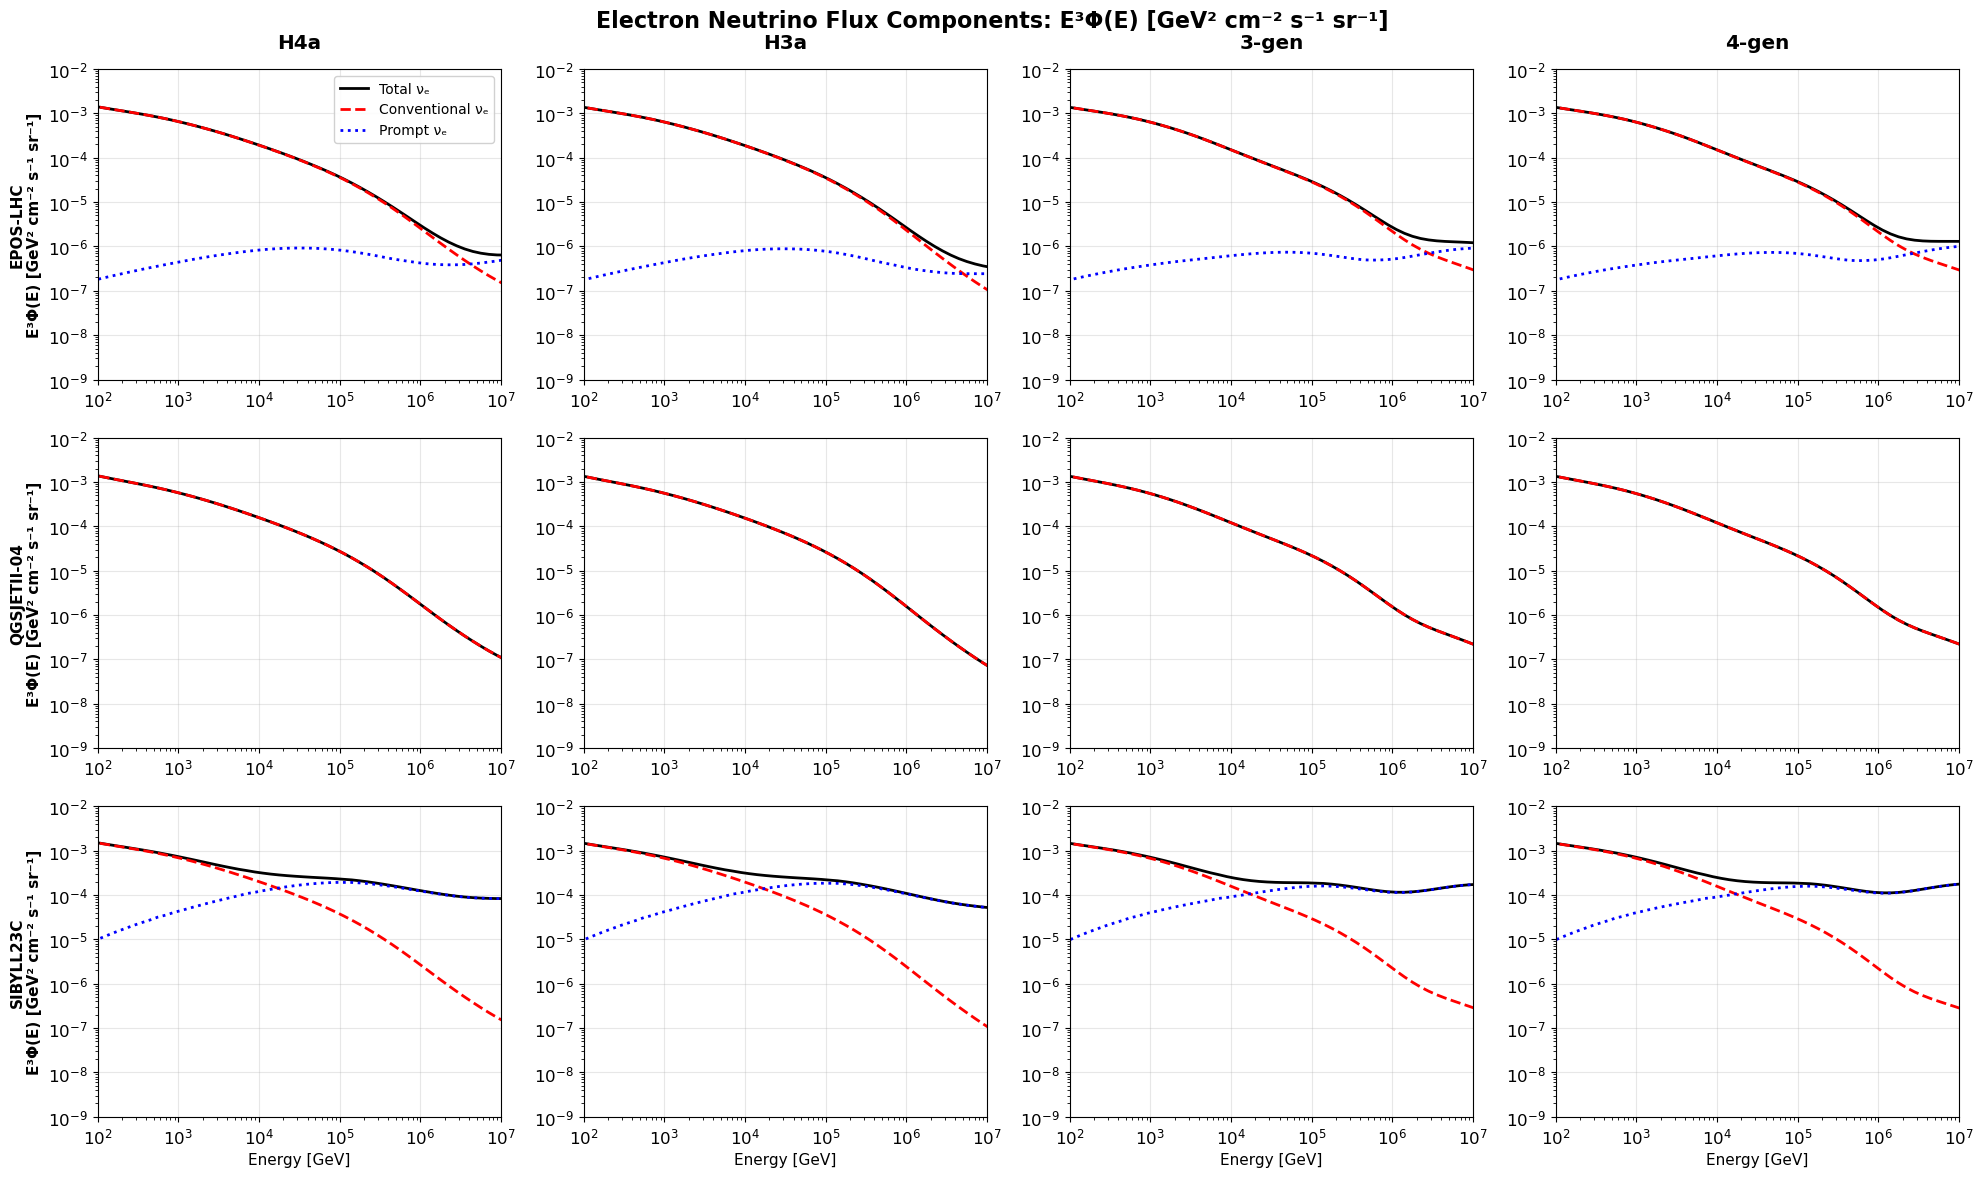

In [29]:
import os
from pathlib import Path

# Get desktop path (works for Windows, Mac, and Linux)
desktop_path = Path.home() / "Desktop"


# Determine the number of primary models
n_primaries = len(primary_models)
n_interactions = len(working_models)

# Create figure with n_interactions rows × n_primaries columns
fig, axes = plt.subplots(n_interactions, n_primaries, figsize=(5*n_primaries, 4*n_interactions))
fig.suptitle(f'Electron Neutrino Flux Components: E³Φ(E) [GeV² cm⁻² s⁻¹ sr⁻¹]\n', 
            fontsize=16, fontweight='bold')

# If only one interaction model, make axes 2D
if n_interactions == 1:
    axes = axes.reshape(1, -1)
if n_primaries == 1:
    axes = axes.reshape(-1, 1)

# Color scheme for flux components
colors = {'nue_total': 'black', 'nue_conv': 'red', 'nue_pr': 'blue'}
linestyles = {'nue_total': '-', 'nue_conv': '--', 'nue_pr': ':'}
labels = {'nue_total': 'Total νₑ', 'nue_conv': 'Conventional νₑ', 'nue_pr': 'Prompt νₑ'}

# Plot data for each combination
for i, int_model in enumerate(working_models):
    for j, prim_model_tuple in enumerate(primary_models):
        prim_name = f"{prim_model_tuple[0].__name__}({prim_model_tuple[1]})"
        ax = axes[i, j]
        
        # Check if we have data for this combination
        if int_model in all_results and prim_name in all_results[int_model]:
            fluxes = all_results[int_model][prim_name]
            
            # Plot each flux component
            for component in ['nue_total', 'nue_conv', 'nue_pr']:
                ax.plot(e_grid, fluxes[component], 
                       color=colors[component], 
                       linestyle=linestyles[component],
                       linewidth=2, 
                       label=labels[component])
            
            # Plot formatting
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.grid(True, alpha=0.3)
            ax.set_xlim(1e2, 1e7)
            ax.set_ylim(1e-9, 1e-2)
            
            # Titles and labels
            if i == 0:  # Top row
                ax.set_title(f'{prim_model_tuple[1]}', fontweight='bold', pad=15)
            if i == n_interactions - 1:  # Bottom row
                ax.set_xlabel('Energy [GeV]', fontsize=11)
            if j == 0:  # Left column
                ax.set_ylabel(f'{int_model}\nE³Φ(E) [GeV² cm⁻² s⁻¹ sr⁻¹]', 
                            fontsize=11, fontweight='bold')
            
            # Add legend to first subplot only
            if i == 0 and j == 0:
                ax.legend(loc='upper right', framealpha=0.9, fontsize=10)
        
        else:
            # No data available
            ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=14, color='red')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.grid(True, alpha=0.3)
            if i == 0:
                ax.set_title(f'{prim_model_tuple[1]}', fontweight='bold', pad=15)
            if j == 0:
                ax.set_ylabel(f'{int_model}\nE³Φ(E)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.93)

# Save the main plot to desktop
main_plot_filename = desktop_path / "neutrino_flux_matrix_plot.png"
plt.savefig(main_plot_filename, dpi=300, bbox_inches='tight', facecolor='white')

plt.show()


EPOS-LHC
{'color': 'green', 'linestyle': '-'}
EPOS-LHC
{'color': 'green', 'linestyle': '-'}
EPOS-LHC
{'color': 'green', 'linestyle': '-'}
EPOS-LHC
{'color': 'green', 'linestyle': '-'}
QGSJETII-04
{'color': 'red', 'linestyle': '-'}
QGSJETII-04
{'color': 'red', 'linestyle': '-'}
QGSJETII-04
{'color': 'red', 'linestyle': '-'}
QGSJETII-04
{'color': 'red', 'linestyle': '-'}
SIBYLL23C
{'color': 'blue', 'linestyle': '-'}
SIBYLL23C
{'color': 'blue', 'linestyle': '-'}
SIBYLL23C
{'color': 'blue', 'linestyle': '-'}
SIBYLL23C
{'color': 'blue', 'linestyle': '-'}


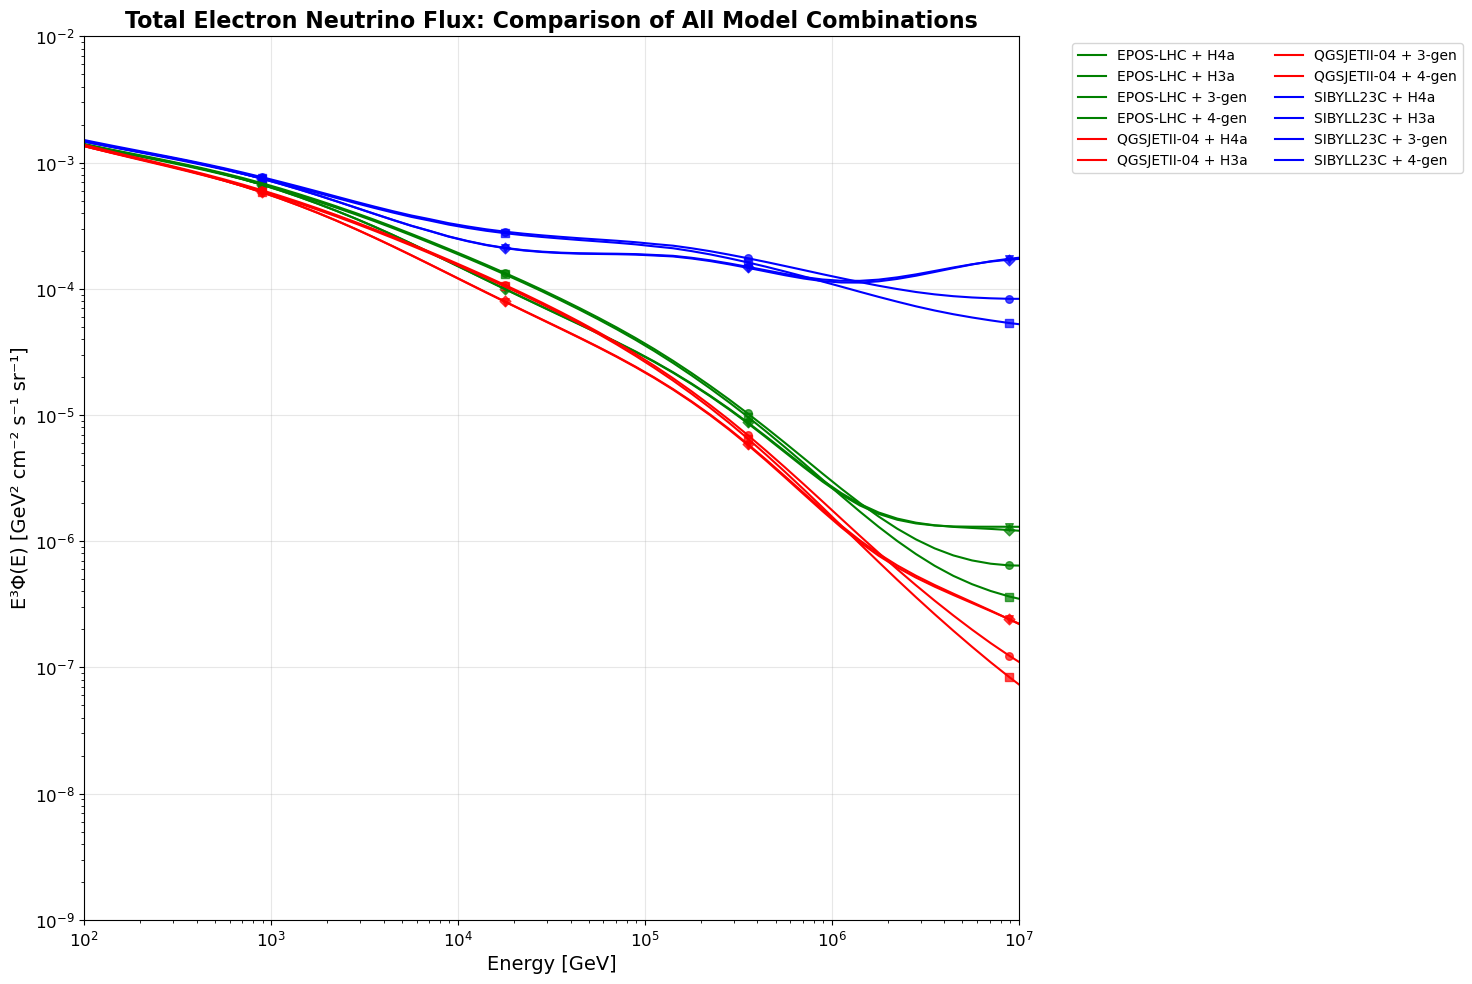

In [20]:


# Create a single plot comparing all combinations
plt.figure(figsize=(15, 10))

# Define colors and linestyles for different combinations
int_model_styles = {
    'SIBYLL23C': {'color': 'blue', 'linestyle': '-'},
    'QGSJETII-04': {'color': 'red', 'linestyle': '-'},
    'EPOS-LHC': {'color': 'green', 'linestyle': '-'},
    'SIBYLL2.3c': {'color': 'blue', 'linestyle': '- -'},
    'QGSJETII-03': {'color': 'red', 'linestyle': '- -'},
    'EPOS1.99': {'color': 'green', 'linestyle': '- -'},
}

prim_model_markers = {
    'H4a': 'o', 'H3a': 's', 'H2a': '^',
    '3-gen': 'D', '4-gen': 'v', '5-gen': '<',
    'GSF': '>', 'TIG': 'p', 'default': '*'
}

# Plot total electron neutrino flux for all combinations
plotted_labels = set()  # To avoid duplicate labels

for i, int_model in enumerate(working_models):
    for j, prim_model_tuple in enumerate(primary_models):
        prim_name = f"{prim_model_tuple[0].__name__}({prim_model_tuple[1]})"
        prim_short = prim_model_tuple[1]
        
        if int_model in all_results and prim_name in all_results[int_model]:
            fluxes = all_results[int_model][prim_name]
            print(int_model)
            # Get style for this combination
            style = int_model_styles.get(int_model, {'color': f'C{i}', 'linestyle': '-'})
            print(style)
            marker = prim_model_markers.get(prim_short, 'o')
            
            label = f'{int_model} + {prim_short}'
            if label not in plotted_labels:
                # Plot every 10th point with marker for clarity
                plt.plot(e_grid, fluxes['nue_total'], 
                        color=style['color'], 
                        linestyle=style['linestyle'],
                        linewidth=1.5,
                        label=label)
                
                # Add markers to some points
                indices = np.linspace(0, len(e_grid)-1, 10, dtype=int)
                plt.scatter(e_grid[indices], fluxes['nue_total'][indices],
                           color=style['color'], 
                           marker=marker,
                           s=30, alpha=0.7)
                
                plotted_labels.add(label)

# Plot formatting
plt.xscale('log')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.xlabel('Energy [GeV]', fontsize=14)
plt.ylabel('E³Φ(E) [GeV² cm⁻² s⁻¹ sr⁻¹]', fontsize=14)
plt.title('Total Electron Neutrino Flux: Comparison of All Model Combinations', fontsize=16, fontweight='bold')
plt.xlim(1e2, 1e7)
plt.ylim(1e-9, 1e-2)

# Legend with reasonable size
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=2)

plt.tight_layout()

# Save the comparison plot to desktop
comparison_plot_filename = desktop_path / "neutrino_flux_comparison_plot.png"
plt.savefig(comparison_plot_filename, dpi=300, bbox_inches='tight', facecolor='white')


plt.show()


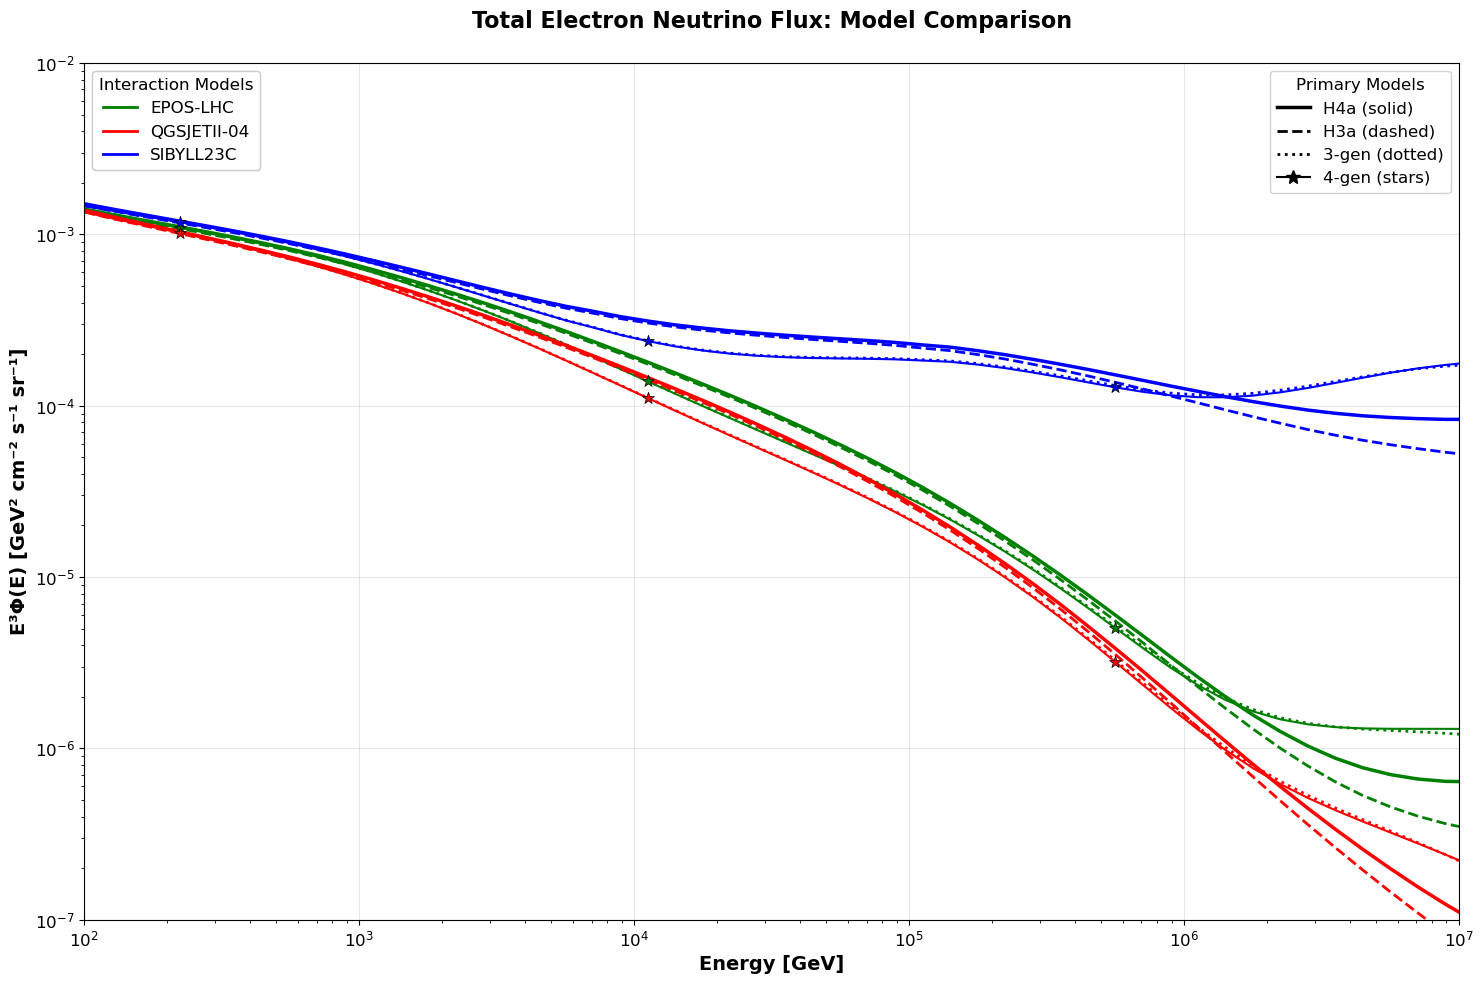

In [28]:

# Create a single plot comparing only the selected models
plt.figure(figsize=(15, 10))

# Define colors for the three selected interaction models
int_model_colors = {
    'SIBYLL23C': 'blue',
    'QGSJETII-04': 'red', 
    'EPOS-LHC': 'green'
}

# Define line styles for primary models (as requested)
prim_model_styles = {
    'H4a': {'linestyle': '-', 'linewidth': 2.5},
    'H3a': {'linestyle': '--', 'linewidth': 2.0},
    '3-gen': {'linestyle': ':', 'linewidth': 2.0},
    '4-gen': {'linestyle': '-', 'linewidth': 1.5}
}

# Only these three interaction models
selected_models = ['EPOS-LHC', 'QGSJETII-04', 'SIBYLL23C']

# Plot total electron neutrino flux for selected combinations
for int_model in selected_models:
    # Skip if this model didn't work
    if int_model not in working_models:
        
        continue
        
    for prim_model_tuple in primary_models:
        prim_name = f"{prim_model_tuple[0].__name__}({prim_model_tuple[1]})"
        prim_short = prim_model_tuple[1]
        
        # Only plot the requested primary models
        if prim_short not in ['H4a', 'H3a', '3-gen', '4-gen']:
            continue
            
        if int_model in all_results and prim_name in all_results[int_model]:
            fluxes = all_results[int_model][prim_name]
            
            # Get color for interaction model
            color = int_model_colors.get(int_model, 'black')
            
            # Get line style for primary model
            prim_style = prim_model_styles.get(prim_short, {'linestyle': '-', 'linewidth': 1.5})
            
            # Create label
            label = f'{int_model} + {prim_short}'
            
            # Plot the line
            line = plt.plot(e_grid, fluxes['nue_total'], 
                           color=color, 
                           linestyle=prim_style['linestyle'],
                           linewidth=prim_style['linewidth'],
                           label=label)
            
            # Add markers for 4-gen model
            if prim_short == '4-gen':
                # Add star markers at selected energy points
                indices = np.linspace(0, len(e_grid)-1, 8, dtype=int)
                plt.scatter(e_grid[indices], fluxes['nue_total'][indices],
                           color=color, 
                           marker='*',
                           s=80,  # Larger size for stars
                           edgecolor='black',
                           linewidth=0.5,
                           zorder=5)  # Ensure markers are on top

# Plot formatting
plt.xscale('log')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.xlabel('Energy [GeV]', fontsize=14, fontweight='bold')
plt.ylabel('E³Φ(E) [GeV² cm⁻² s⁻¹ sr⁻¹]', fontsize=14, fontweight='bold')
plt.title('Total Electron Neutrino Flux: Model Comparison\n',fontsize=16, fontweight='bold')
plt.xlim(1e2, 1e7)
plt.ylim(1e-7, 1e-2)

# Create custom legend entries to show line style meanings
from matplotlib.lines import Line2D

# Create custom legend elements for primary models
primary_legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=2.5, label='H4a (solid)'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2.0, label='H3a (dashed)'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2.0, label='3-gen (dotted)'),
    Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, marker='*', 
           markersize=10, label='4-gen (stars)')
]

# Create custom legend elements for interaction models
interaction_legend_elements = []
for int_model in selected_models:
    if int_model in working_models:  # Only include if it worked
        color = int_model_colors.get(int_model, 'black')
        interaction_legend_elements.append(
            Line2D([0], [0], color=color, linestyle='-', linewidth=2, label=int_model)
        )

# Create two separate legends
legend1 = plt.legend(handles=primary_legend_elements, 
                    loc='upper right', 
                    title='Primary Models',
                    title_fontsize=12,
                    framealpha=0.9)

legend2 = plt.legend(handles=interaction_legend_elements, 
                    loc='upper left', 
                    title='Interaction Models',
                    title_fontsize=12,
                    framealpha=0.9)

# Add both legends to the plot
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.tight_layout()

# Save the comparison plot to desktop
comparison_plot_filename = desktop_path / "neutrino_flux_selected_models.png"
plt.savefig(comparison_plot_filename, dpi=300, bbox_inches='tight', facecolor='white')


plt.show()
